# Notebook Demo: Using SAM 2 for Automatic Mask Generation
This notebook demonstrates how to use the Segment Anything Model 2 (SAM 2) to generate segmentation maps for pre-event and post-event images in remote sensing data. We will use SAM 2's `SAM2AutomaticMaskGenerator` to generate segmentation masks for the input images.

## Outline
1. **Introduction**: Overview of the notebook and objectives.
2. **Importing Required Libraries**: Importing the necessary Python libraries and modules.
3. **Loading Sample Data**: Loading the pre-event and post-event image pairs from the dataset.
4. **Loading SAM 2 Model**: Setting up the SAM 2 model for mask generation.
5. **Generating Segmentation Masks**: Generating segmentation masks for the input images.
6. **Displaying Results**: Visualizing the generated segmentation masks.
7. **Notes**: Additional information and next steps.

**Steps Covered:**
1. Importing required libraries
2. Loading sample image pairs from the dataset
3. Loading the SAM 2 model
4. Generating segmentation masks
5. Displaying results


### Step 1: Import Required Libraries
Import necessary Python libraries and modules.

In [1]:
import os
import sys

# Add SAM2 source code to the Python path
sam2_repo_root = '/g22338035czy/SAM2'
sys.path.insert(0, os.path.join(sam2_repo_root, ''))
print(sys.path)

['/g22338035czy/SAM2/', '/opt/conda/envs/genai1025/lib/python310.zip', '/opt/conda/envs/genai1025/lib/python3.10', '/opt/conda/envs/genai1025/lib/python3.10/lib-dynload', '', '/opt/conda/envs/genai1025/lib/python3.10/site-packages']


In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.sam2_image_predictor import SAM2ImagePredictor

Fontconfig error: Cannot load default config file: No such file: (null)


### Step 2: Load Sample Data (Pre-Event and Post-Event Image Pairs)
Load the pre-event and post-event image pairs. Replace the paths with your own remote sensing images.

In [3]:


# Generate paths for pre-event and post-event images
pre_event_img_path = "../sample-data/hurricane-florence_00000109_pre_disaster.png"
post_event_img_path = "../sample-data/hurricane-florence_00000109_post_disaster.png"

# Load images
pre_event_image = Image.open(pre_event_img_path).convert("RGB")
post_event_image = Image.open(post_event_img_path).convert("RGB")

### Step 3: Load SAM 2 Model
Load the SAM 2 model for segmentation mask generation.

In [16]:

# Set paths to the SAM 2 checkpoint and configuration
sam2_checkpoint = "../../models/facebook/sam2.1-hiera-large/sam2.1_hiera_large.pt"
model_cfg = "../../models/facebook/sam2.1-hiera-large/sam2.1_hiera_l.yaml"


# Select the device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

# Build the SAM 2 model
sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

# Create an instance of SAM2AutomaticMaskGenerator
mask_generator = SAM2AutomaticMaskGenerator(sam2)
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=32,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)
mask_generator=mask_generator_2

using device: cuda


### Step 4: Generate Segmentation Masks for Pre-Event and Post-Event Images
Generate segmentation masks for both pre-event and post-event images.

In [17]:
# Convert pre-event image to numpy array
pre_event_image_np = np.array(pre_event_image)

# Generate masks for the pre-event image
masks_pre_event = mask_generator.generate(pre_event_image_np)
print(f"Number of masks generated for pre-event image: {len(masks_pre_event)}")

# Convert post-event image to numpy array
post_event_image_np = np.array(post_event_image)

# Generate masks for the post-event image
masks_post_event = mask_generator.generate(post_event_image_np)
print(f"Number of masks generated for post-event image: {len(masks_post_event)}")

Number of masks generated for pre-event image: 65
Number of masks generated for post-event image: 53


### Step 5: Display Results
Visualize the segmentation masks generated for both pre-event and post-event images.

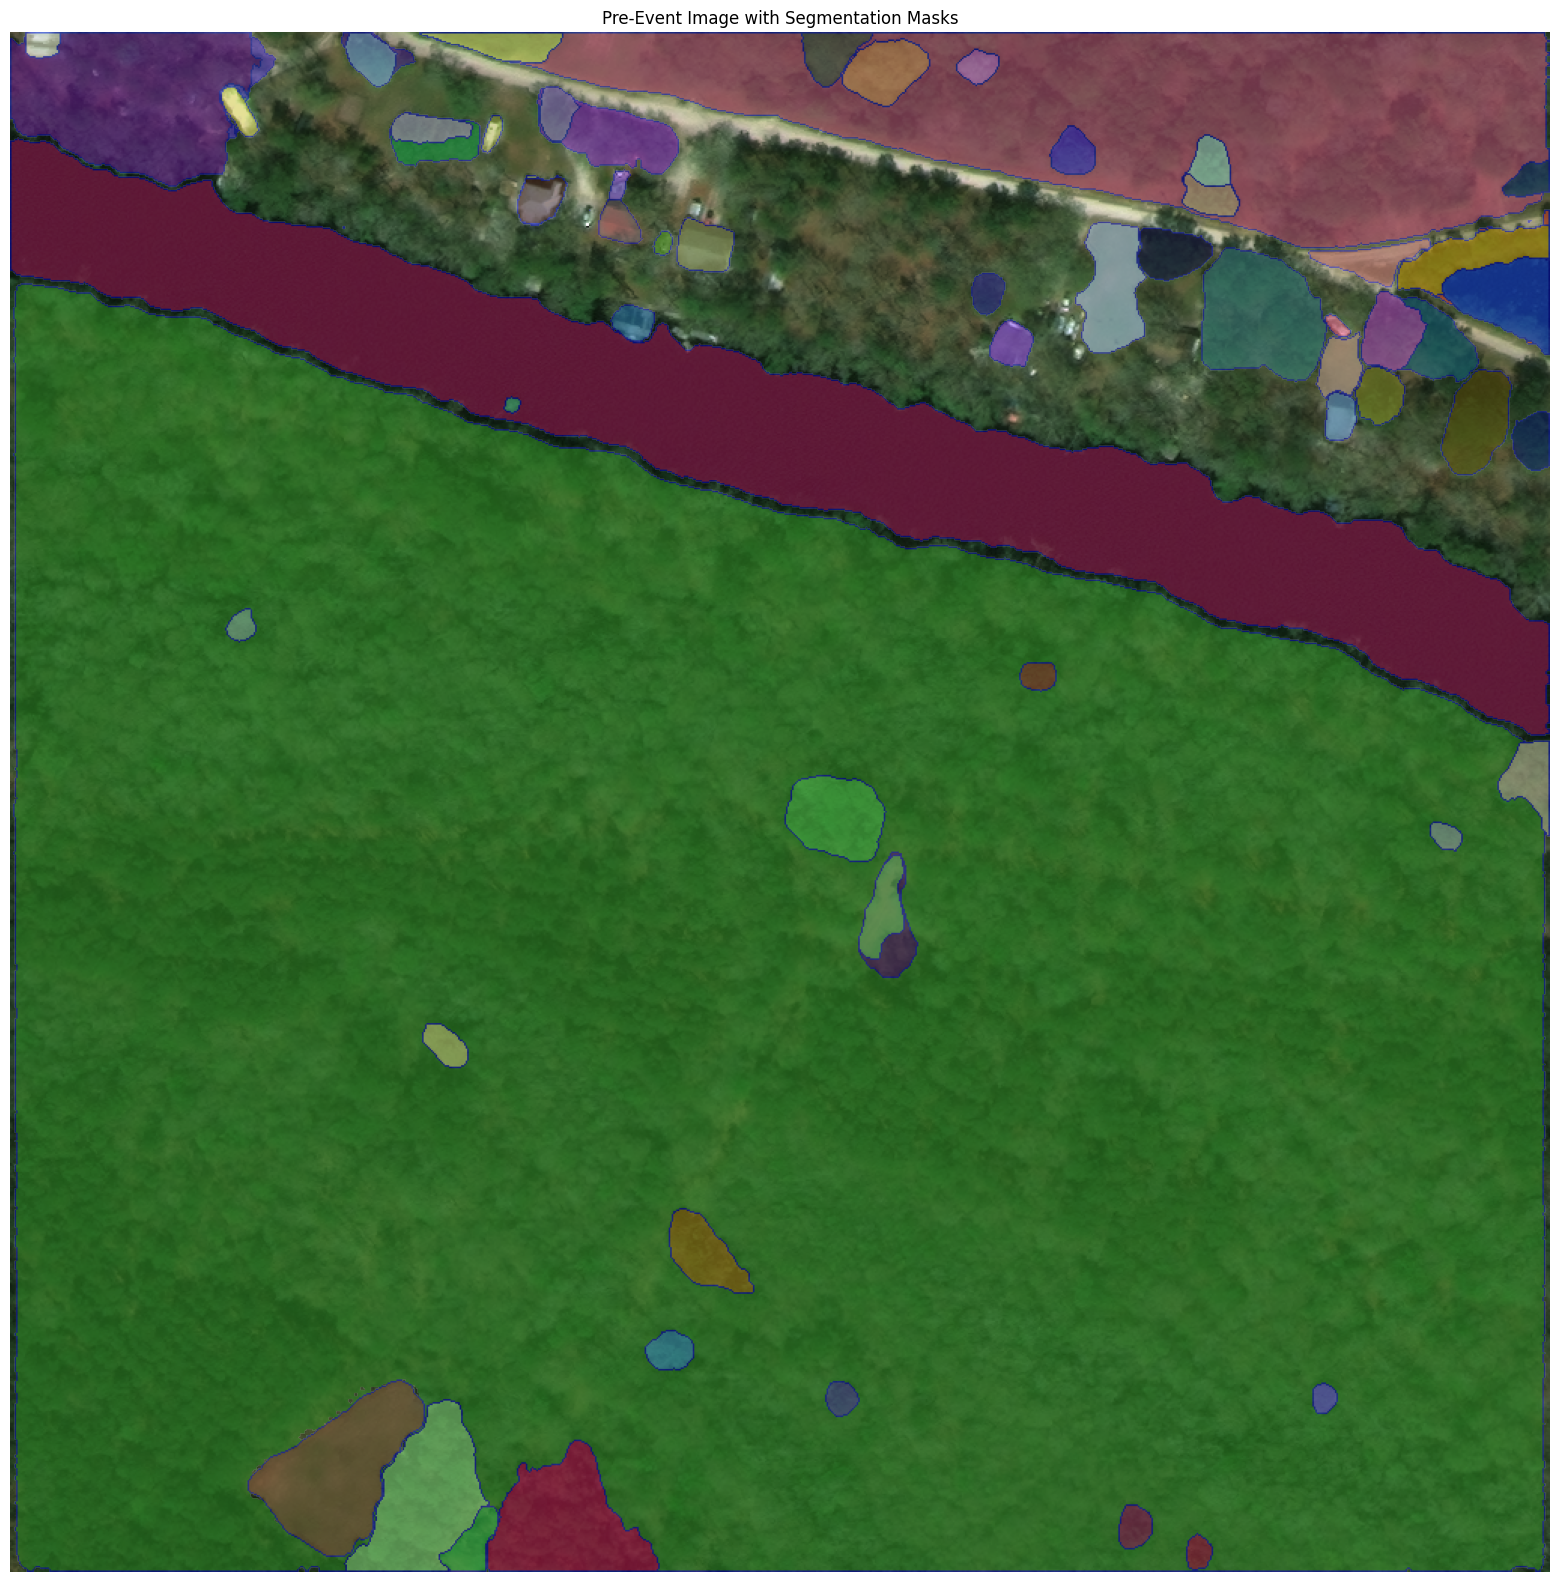

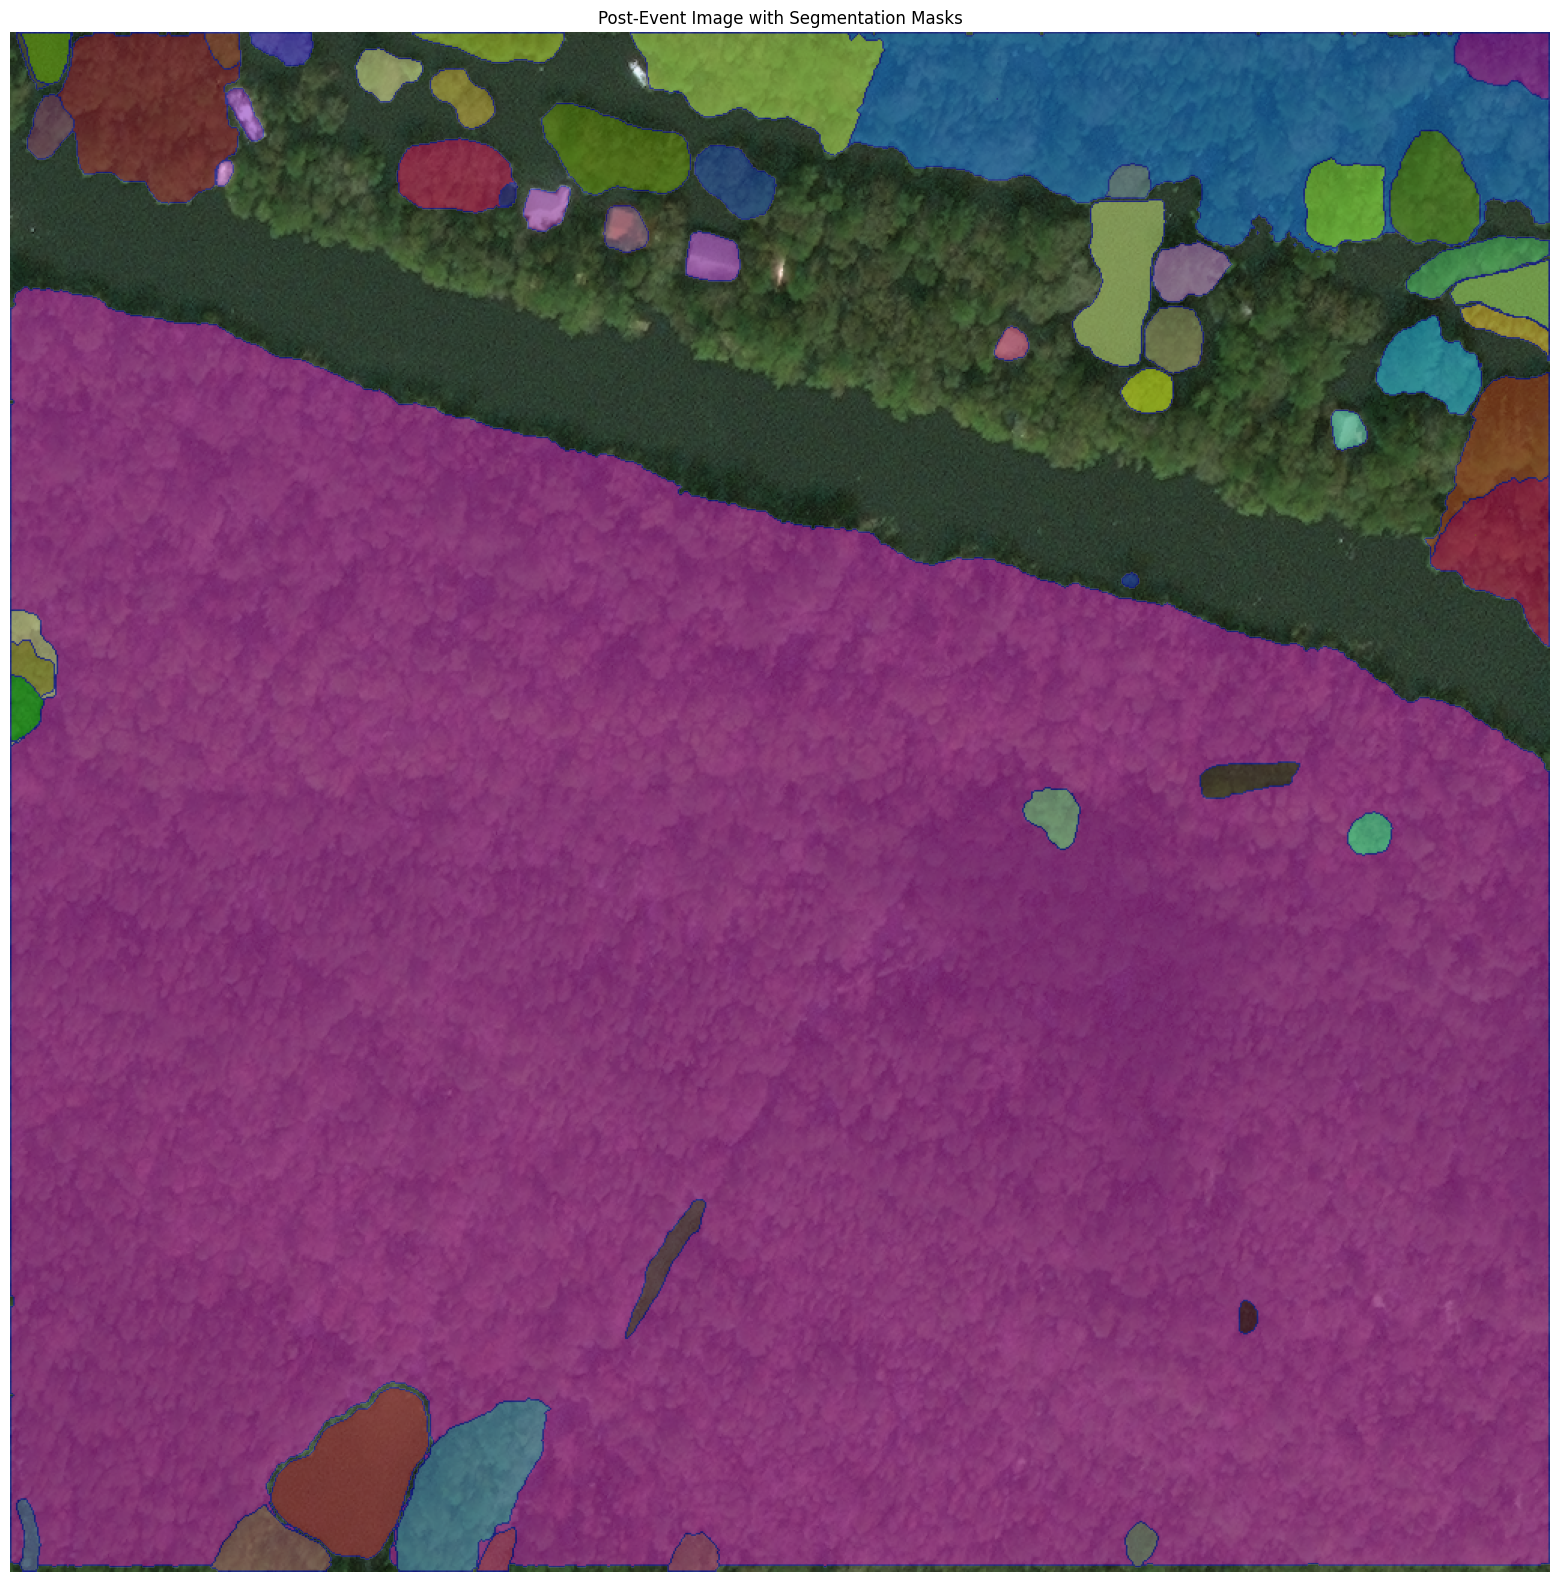

In [18]:
# Define a function to display annotations
def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

# Display pre-event image and its masks
plt.figure(figsize=(20, 20))
plt.imshow(pre_event_image)
plt.title("Pre-Event Image with Segmentation Masks")
show_anns(masks_pre_event)
plt.axis('off')
plt.show()

# Display post-event image and its masks
plt.figure(figsize=(20, 20))
plt.imshow(post_event_image)
plt.title("Post-Event Image with Segmentation Masks")
show_anns(masks_post_event)
plt.axis('off')
plt.show()

### Notes
- The current implementation uses SAM 2 for segmentation mask generation. Additional parameters can be tuned to adjust the quality and number of masks generated.
- Experiment with different input images and mask generation options for more detailed segmentation results.